In [1]:
"""Markov Decision Processes (Chapter 17)

First we define an MDP, and the special case of a GridMDP, in which
states are laid out in a 2-dimensional grid. We also represent a policy
as a dictionary of {state: action} pairs, and a Utility function as a
dictionary of {state: number} pairs. We then define the value_iteration
and policy_iteration algorithms.
"""

'Markov Decision Processes (Chapter 17)\n\nFirst we define an MDP, and the special case of a GridMDP, in which\nstates are laid out in a 2-dimensional grid. We also represent a policy\nas a dictionary of {state: action} pairs, and a Utility function as a\ndictionary of {state: number} pairs. We then define the value_iteration\nand policy_iteration algorithms.\n'

In [2]:
import random
from collections import defaultdict
from scipy.stats import norm
import numpy as np
import pytest
from utils import vector_add, orientations, turn_right, turn_left
from math import isclose
import matplotlib.pyplot as plt

In [3]:
# @title Plotting Functions

def plot_fish(fish_state, ax=None, show=True):
  """
  Plot the fish dynamics (states across time)
  """
  T = len(fish_state)

  offset = 3

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  x = np.arange(0, T, 1)
  y = offset * (fish_state*2 - 1)

  ax.plot(y, color='cornflowerblue', markersize=10, linewidth=3.0, zorder=0)
  ax.fill_between(x, y, color='cornflowerblue', alpha=.3)

  ax.set_xlabel('time')
  ax.set_ylabel('Chosen location')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-(offset+.5), offset+.5])
  ax.set_yticks([-offset, offset])
  ax.set_yticklabels(['right', 'left'])

  ax.spines['bottom'].set_position('center')
  if show:
    plt.show()


def plot_measurement(measurement, ax=None, show=True):
  """
  Plot the measurements
  """
  T = len(measurement)

  rel_pos = 3
  red_y = []
  blue_y = []
  for idx, value in enumerate(measurement):
    if value == 0:
      blue_y.append([idx, -rel_pos])
    else:
      red_y.append([idx, rel_pos])

  red_y = np.asarray(red_y)
  blue_y = np.asarray(blue_y)

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  if len(red_y) > 0:
    ax.plot(red_y[:, 0], red_y[:, 1], '*', markersize=8, color='crimson')

  if len(blue_y) > 0:
    ax.plot(blue_y[:, 0], blue_y[:, 1], '*', markersize=8, color='royalblue')

  ax.set_xlabel('time', fontsize=18)
  ax.set_ylabel('Caught fish?')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-rel_pos - .5, rel_pos + .5])
  ax.set_yticks([-rel_pos, rel_pos])
  ax.set_yticklabels(['no', 'yes!'])

  ax.spines['bottom'].set_position('center')
  if show:
    plt.show()


def plot_act_loc(loc, act, ax_loc=None, show=True):
  """
  Plot the action and location of T time points
  """
  T = len(act)

  if not ax_loc:
    fig, ax_loc = plt.subplots(1, 1, figsize=(12, 2.5))

  loc = loc*2 - 1
  act_down = []
  act_up = []
  for t in range(1, T):
    if loc[t-1] == -1 and loc[t] == 1:
      act_up.append([t - 0.5, 0])
    if loc[t-1] == 1 and loc[t] == -1:
      act_down.append([t - 0.5, 0])

  act_down = np.array(act_down)
  act_up = np.array(act_up)

  ax_loc.plot(loc, 'g.-', markersize=8, linewidth=5)

  if len(act_down) > 0:
    ax_loc.plot(act_down[:, 0], act_down[:, 1], 'rv', markersize=18, zorder=10, label='switch')

  if len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10)

  ax_loc.set_xlabel('time')
  ax_loc.set_ylabel('Your state')

  ax_loc.set_xlim([0, T])
  ax_loc.set_xticks([])
  ax_loc.xaxis.set_label_coords(1.05, .54)

  if len(act_down) > 0:
    ax_loc.legend(loc="upper right")
  elif len(act_down) == 0 and len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10, label='switch')
    ax_loc.legend(loc="upper right")

  ax_loc.set_ylim([-1.1, 1.1])
  ax_loc.set_yticks([-1, 1])

  ax_loc.tick_params(axis='both', which='major')
  ax_loc.set_yticklabels(['left', 'right'])

  ax_loc.spines['bottom'].set_position('center')

  if show:
    plt.show()


def plot_belief(belief, ax1=None, choose_policy=None, show=True):
  """
  Plot the belief dynamics of T time points
  """

  T = belief.shape[1]

  if not ax1:
      fig, ax1 = plt.subplots(1, 1, figsize=(12, 2.5))

  ax1.plot(belief[1, :], color='midnightblue', markersize=10, linewidth=3.0)

  ax1.set_xlabel('time')
  ax1.set_ylabel('Belief (right)')

  ax1.set_xlim([0, T])
  ax1.set_xticks([])
  ax1.xaxis.set_label_coords(1.05, 0.05)

  ax1.set_yticks([0, 1])
  ax1.set_ylim([0, 1.1])

  labels = [item.get_text() for item in ax1.get_yticklabels()]
  ax1.set_yticklabels(['    0', '    1'])

  """
  if choose_policy == "threshold":
    ax2 = ax1.twinx()
    ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
    ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
    ax2.set_yticks([threshold, 1 - threshold])
    ax2.set_ylim([0, 1.1])
    ax2.tick_params(axis='both', which='major', labelsize=18)
    labels = [item.get_text() for item in ax2.get_yticklabels()]
    labels[0] = 'threshold to switch \n from left to right'
    labels[-1] = 'threshold to switch \n from right to left'
    ax2.set_yticklabels(labels)
  """
  if show:
    plt.show()


def plot_dynamics(belief, loc, act, meas, fish_state, choose_policy):
  """
  Plot the dynamics of T time points
  """
  if choose_policy == 'threshold':
    fig, [ax0, ax_bel, ax_loc, ax1] = plt.subplots(4, 1, figsize=(12, 9))
    plot_fish(fish_state, ax=ax0, show=False)
    plot_belief(belief, ax1=ax_bel, show=False)
    plot_measurement(meas, ax=ax1, show=False)
    plot_act_loc(loc, act, ax_loc=ax_loc)
  else:
    fig, [ax0, ax_bel, ax1] = plt.subplots(3, 1, figsize=(12, 7))
    plot_fish(fish_state, ax=ax0, show=False)
    plot_belief(belief, ax1=ax_bel, show=False)
    plot_measurement(meas, ax=ax1, show=False)

  plt.tight_layout()
  plt.show()


def belief_histogram(belief, bins=100):
  """
  Plot the histogram of belief states
  """
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.hist(belief, bins)
  ax.set_xlabel('belief', fontsize=18)
  ax.set_ylabel('count', fontsize=18)
  plt.show()


def plot_value_threshold(threshold_array, value_array):
  """
  Helper function to plot the value function and threshold
  """
  yrange = np.max(value_array) - np.min(value_array)
  star_loc = np.argmax(value_array)

  fig_, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.plot(threshold_array, value_array, 'b')
  ax.vlines(threshold_array[star_loc],
            min(value_array) - yrange * .1, max(value_array),
            colors='red', ls='--')
  ax.plot(threshold_array[star_loc],
          value_array[star_loc],
          '*', color='crimson',
          markersize=20)

  ax.set_ylim([np.min(value_array) - yrange * .1,
               np.max(value_array) + yrange * .1])
  ax.set_title(f'threshold vs value with switching cost c = {cost_sw:.2f}',
               fontsize=20)
  ax.set_xlabel('threshold', fontsize=16)
  ax.set_ylabel('value', fontsize=16)
  plt.show()

In [4]:
class MDP:

    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [page 646]"""

    def __init__(self, init, actlist, terminals, transitions = {}, reward = None, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            ## collect states from transitions table
            self.states = self.get_states_from_transitions(transitions)
            
        
        self.init = init
        
        if isinstance(actlist, list):
            ## if actlist is a list, all states have the same actions
            self.actlist = actlist
        elif isinstance(actlist, dict):
            ## if actlist is a dict, different actions for each state
            self.actlist = actlist
        
        self.terminals = terminals
        self.transitions = transitions
        if self.transitions == {}:
            print("Warning: Transition table is empty.")
        self.gamma = gamma
        if reward:
            self.reward = reward
        else:
            self.reward = {s : 0 for s in self.states}
        #self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set([tr[1] for actions in transitions.values() 
                              for effects in actions.values() for tr in effects])
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):
        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)
        # check that init is a valid state
        assert self.init in self.states
        # check reward for each state
        #assert set(self.reward.keys()) == set(self.states)
        assert set(self.reward.keys()) == set(self.states)
        # check that all terminals are valid states
        assert all([t in self.states for t in self.terminals])
        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

In [5]:

# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

In [6]:
class CustomMDP(MDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        MDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.t[state][action]

In [7]:
our_mdp = CustomMDP(init, terminals, t, rewards, gamma=.9)

In [8]:
class GridMDP(MDP):
    """A two-dimensional grid MDP, as in [Figure 17.1]. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x]:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions=transitions,
                     reward=reward, states=states, gamma=gamma)
    def calculate_T(self, state, action):
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
        else:
            return [(0.0, state)]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""

        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""

        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})
        

In [9]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration. [Figure 17.4]"""

    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    print(T)
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            
            U1[s] = R(s) + gamma * max(sum(p * U[s1] for (p, s1) in T(s, a))
                                       for a in mdp.actions(s))
            delta = max(delta, abs(U1[s] - U[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return U


def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action. [Equation 17.4]"""

    pi = {}
    for s in mdp.states:
        pi[s] = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi


def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""

    return sum(p * U[s1] for (p, s1) in mdp.T(s, a))


# ______________________________________________________________________________


def policy_iteration(mdp):
    """Solve an MDP by policy iteration [Figure 17.7]"""

    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi


def policy_evaluation(pi, U, mdp, k=20):
    """Return an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum(p * U[s1] for (p, s1) in T(s, pi[s]))
    return U


In [60]:
class POMDP(MDP):
    """A Partially Observable Markov Decision Process, defined by
    a transition model P(s'|s,a), actions A(s), a reward function R(s),
    and a sensor model P(e|s). We also keep track of a gamma value,
    for use by algorithms. The transition and the sensor models
    are defined as matrices. We also keep track of the possible states
    and actions for each state. [Page 659]."""

    def __init__(self, actions, transitions=None, rewards=None, states=None, p_stay = 0.95, sigmaAttention = np.array([.1, .02]), gamma=0.95, Initial_Loc = 1):
        """Initialize variables of the pomdp"""
        # 0: left state and choosing left as an action and vice versa for 1
        if not (0 <= gamma <= 1):
            raise ValueError('A POMDP must have 0 < gamma <= 1')
        #p_stay and sigma attention are related to updating the belief 
        self.p_stay = p_stay
        self.sigmaAttention = sigmaAttention
        self.states = states
        self.actions = actions
        self.rewards = rewards
        # transition model cannot be undefined
        # transitions = p_stay
        self.transitions = transitions
        #t_prob is (2,2,2) 3d matrix. First dimension determines the action choice. Second dimension determines the state the agent was in.
        self.t_prob = np.array([[[self.transitions,1-self.transitions],[self.transitions,1-self.transitions]],[[self.transitions,1-self.transitions],[self.transitions,1-self.transitions]]])
        # """if not self.t_prob:
        # print('Warning: Transition model is undefined')"""

        '''# sensor model cannot be undefined
        # self.e_prob = evidences or {}
        # if not self.e_prob:
        #     print('Warning: Sensor model is undefined')'''

        self.gamma = gamma
    
        #prev_state determines the previous action
        self.prev_state = Initial_Loc
        # history is a number that determines the number of same actions which are chosen consequently
        self.history = 1
        # These lists are defined to save previous variants
        self.actlist = [Initial_Loc]
        self.statelist = [Initial_Loc]
        self.belieflist = []
        self.rewardlist = [[],[]]
        # Initial reward (It is randomy assigned)
        # The dimensions of the reward array determine from which state the agent goes to which state
        self.reward_arr = np.array([[2,0],[0,2]],dtype=float)
        
        rand_ = np.random.random()
        #Initialize the past belief 
        self.belief_past = rand_
        self.belieflist = [self.belief_past]
        self.e_prob = np.array([rand_,1-rand_])

    # chooses the actions based on the maximum utility of the previous state 
    def selected_action(self, action : list):
        act = action[int(self.prev_state)]
        return act
    
    # Based on the chosen action and transition probabilities, it determines which state would be the next one which the agent will be placed
    def last_state(self, action):
        action = str(action)
        opposite_action = str(abs(1-int(action)))
        # print(self.prev_state)
        # print(action)
        state = np.random.choice([action,opposite_action],p=self.t_prob[int(action),int(self.prev_state)])
        return state
    
    # updates the reward, it generates a (2,2) array (more explanation in reward_arr initialization)
    def reward_set (self):

        """reward[0, t] = biasRewFactorLeft * rewDom * np.exp(-t_inSw/expts)
            rewards = (biasRewFactorLeft, biasRewFactorRight, rewDom, rewSupp, expts)
            rewards = (1,                   1,                  10,     2,      5)"""
        biasRewFactorLeft, biasRewFactorRight, rewDom, rewSupp, expts = self.rewards
        biasRewFactor = {'0' : biasRewFactorLeft, '1' : biasRewFactorRight}

        self.reward_arr[0,0] = biasRewFactor["0"] * rewDom * np.exp(-self.history/expts)
        self.reward_arr[0,1] = rewSupp
        self.reward_arr[1,0] = rewSupp
        self.reward_arr[1,1] = biasRewFactor["1"] * rewDom * np.exp(-self.history/expts)

    def belief_update(self):
        
        opp_state = np.abs(1-int(self.prev_state))
        state = int(self.prev_state)
        state = 0
        opp_state = 1
        if state == 0:
            sigma1 = self.sigmaAttention[0] 
            sigma2 = self.sigmaAttention[1] 
        elif state == 1:
            sigma1 = self.sigmaAttention[1] 
            sigma2 = self.sigmaAttention[0]  
        # evaluatuing belief_0
        mu = state
        obsVal = np.random.normal(mu, sigma1, 1)
        obsProb = norm.pdf(obsVal, loc=mu, scale=sigma1)

        belief_0 = (self.belief_past *  self.p_stay  + (1 - self.belief_past) * (1 -  self.p_stay)) * obsProb

        # evaluatuing belief_1
        mu = opp_state
        obsVal = np.random.normal(mu, sigma2, 1)
        obsProb = norm.pdf(obsVal, loc=mu, scale=sigma2)

        belief_1 = ((1-self.belief_past) *  self.p_stay  +  self.belief_past * (1 -  self.p_stay)) * obsProb

        # normalizing beliefs
        norm_belief_0 = belief_0/(belief_0 + belief_1)
        norm_belief_1 = 1 - norm_belief_0
        norm_belief_0 = float(norm_belief_0)
        norm_belief_1 = float(norm_belief_1)
        # belief_arr determines the agents probability of being in each state 
        belief_arr = np.array([norm_belief_0,norm_belief_1])

    
        self.belief_past = norm_belief_0
        self.e_prob = belief_arr
        
    
    #at the end of each point, updates the variants
    def update(self, st, action):
        self.rewardlist[0].append(self.reward_arr[self.prev_state,0])
        self.rewardlist[1].append(self.reward_arr[self.prev_state,1])
        if st != self.prev_state:
            self.prev_state = st
            self.history = 1
        elif st == self.prev_state:
            self.prev_state = st
            self.history += 1
        self.actlist.append(action)
        self.statelist.append(st)
        self.belieflist.append(self.belief_past)

        
        

    def remove_dominated_plans(self, input_values):
        """
        Remove dominated plans.
        This method finds all the lines contributing to the
        upper surface and removes those which don't.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = [values[0]]
        y1_max = max(val[1] for val in values)
        tgt = values[0]
        prev_b = 0
        prev_ix = 0
        while tgt[1] != y1_max:
            min_b = 1
            min_ix = 0
            for i in range(prev_ix + 1, len(values)):
                if values[i][0] - tgt[0] + tgt[1] - values[i][1] != 0:
                    trans_b = (values[i][0] - tgt[0]) / (values[i][0] - tgt[0] + tgt[1] - values[i][1])
                    if 0 <= trans_b <= 1 and trans_b > prev_b and trans_b < min_b:
                        min_b = trans_b
                        min_ix = i
            prev_b = min_b
            prev_ix = min_ix
            tgt = values[min_ix]
            best.append(tgt)

        return self.generate_mapping(best, input_values)

    def remove_dominated_plans_fast(self, input_values):
        """
        Remove dominated plans using approximations.
        Resamples the upper boundary at intervals of 100 and
        finds the maximum values at these points.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = []
        sr = 100
        for i in range(sr + 1):
            x = i / float(sr)
            maximum = (values[0][1] - values[0][0]) * x + values[0][0]
            tgt = values[0]
            for value in values:
                val = (value[1] - value[0]) * x + value[0]
                if val > maximum:
                    maximum = val
                    tgt = value

            if all(any(tgt != v) for v in best):
                best.append(np.array(tgt))

        return self.generate_mapping(best, input_values)

    def generate_mapping(self, best, input_values):
        """Generate mappings after removing dominated plans"""

        mapping = defaultdict(list)
        for value in best:
            for action in input_values:
                if any(all(value == v) for v in input_values[action]):
                    mapping[action].append(value)

        return mapping

    def max_difference(self, U1, U2):
        """Find maximum difference between two utility mappings"""

        for k, v in U1.items():
            sum1 = 0
            for element in U1[k]:
                sum1 += sum(element)
            sum2 = 0
            for element in U2[k]:
                sum2 += sum(element)
        return abs(sum1 - sum2)


In [61]:
# class Matrix:
#     """Matrix operations class"""

#     @staticmethod
#     def add(A, B):
#         """Add two matrices A and B"""

#         res = []
#         for i in range(len(A)):
#             row = []
#             for j in range(len(A[0])):
#                 row.append(A[i][j] + B[i][j])
#             res.append(row)
#         return res

#     @staticmethod
    # def scalar_multiply(a, B):
    #     """Multiply scalar a to matrix B"""

    #     for i in range(len(B)):
    #         for j in range(len(B[0])):
    #             B[i][j] = a * B[i][j]
    #     return B

#     @staticmethod
#     def multiply(A, B):
#         """Multiply two matrices A and B element-wise"""

#         matrix = []
#         for i in range(len(B)):
#             row = []
#             for j in range(len(B[0])):
#                 row.append(B[i][j] * A[j][i])
#             matrix.append(row)

#         return matrix

#     @staticmethod
#     def matmul(A, B):
#         """Inner-product of two matrices"""

#         return [[sum(ele_a * ele_b for ele_a, ele_b in zip(row_a, col_b)) for col_b in list(zip(*B))] for row_a in A]

#     @staticmethod
#     def transpose(A):
#         """Transpose a matrix"""

#         return [list(i) for i in zip(*A)]

In [62]:
def scalar_multiply(a, B):
    """Multiply scalar a to matrix B"""

    for i in range(len(B)):
        for j in range(len(B[0])):
            B[i][j] = a * B[i][j]
    return B

In [63]:
'''POMDP value iteration comes in a cell below'''



# def pomdp_value_iteration(pomdp, epsilon=0.1, Initial_loc=1):
#     """Solving a POMDP by value iteration."""

#     pomdp.update(Initial_loc,Initial_loc)
#     U = {'': [[0] * len(pomdp.states)]}
#     count = 0
#     while True:
#         count += 1
#         prev_U = U
        
#         values = [val for action in U for val in U[action]]
#         # print('val is: ',values , '\n')
#         value_matxs = []
#         for i in values:
#             for j in values:
#                 value_matxs.append([i, j])
#         print('matrixis : ', value_matxs)
#         U1 = defaultdict(list)
#         for action in pomdp.actions:
#             for u in value_matxs:
                
#                 u1 = np.matmul(np.matmul(pomdp.t_prob[int(action)],
#                                                  np.multiply(pomdp.e_prob[int(action)], np.transpose(u))),[[1], [1]])
#                 print('t ', pomdp.t_prob[int(action)],'\n')
#                 print('e ',pomdp.e_prob[int(action)],'\n')
#                 print('trans u ',np.transpose(u),'\n')
#                 print('u ',u,'\n')
#                 print('u1 ',u1)
#                 print(2*'\n')
#                 u1 = np.add((pomdp.gamma* np.transpose(u1)), [pomdp.rewards[int(action)]])
#                 U1[action].append(u1[0])

#         U = pomdp.remove_dominated_plans_fast(U1)
#         action = [str(np.argmax(U['0'])),str(np.argmax(U['1']))]
#         act = pomdp.selected_action(action)
#         state = pomdp.last_state(act)
#         pomdp.update(act,state)
#         # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations

#         if count > 10:
#             if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
#                 return U

'POMDP value iteration comes in a cell below'

In [64]:
# random.seed("aima-python")

sequential_decision_environment_1 = GridMDP([[-0.1, -0.1, -0.1, +1],
                                             [-0.1, None, -0.1, -1],
                                             [-0.1, -0.1, -0.1, -0.1]],
                                            terminals=[(3, 2), (3, 1)])

sequential_decision_environment_2 = GridMDP([[-2, -2, -2, +1],
                                             [-2, None, -2, -1],
                                             [-2, -2, -2, -2]],
                                            terminals=[(3, 2), (3, 1)])

sequential_decision_environment_3 = GridMDP([[-1.0, -0.1, -0.1, -0.1, -0.1, 0.5],
                                             [-0.1, None, None, -0.5, -0.1, -0.1],
                                             [-0.1, None, 1.0, 3.0, None, -0.1],
                                             [-0.1, -0.1, -0.1, None, None, -0.1],
                                             [0.5, -0.1, -0.1, -0.1, -0.1, -1.0]],
                                            terminals=[(2, 2), (3, 2), (0, 4), (5, 0)])


def test_value_iteration():
    assert value_iteration(sequential_decision_environment, .01) == {
        (3, 2): 1.0, (3, 1): -1.0,
        (3, 0): 0.12958868267972745, (0, 1): 0.39810203830605462,
        (0, 2): 0.50928545646220924, (1, 0): 0.25348746162470537,
        (0, 0): 0.29543540628363629, (1, 2): 0.64958064617168676,
        (2, 0): 0.34461306281476806, (2, 1): 0.48643676237737926,
        (2, 2): 0.79536093684710951}

    assert value_iteration(sequential_decision_environment_1, .01) == {
        (3, 2): 1.0, (3, 1): -1.0,
        (3, 0): -0.0897388258468311, (0, 1): 0.146419707398967840,
        (0, 2): 0.30596200514385086, (1, 0): 0.010092796415625799,
        (0, 0): 0.00633408092008296, (1, 2): 0.507390193380827400,
        (2, 0): 0.15072242145212010, (2, 1): 0.358309043654212570,
        (2, 2): 0.71675493618997840}

    assert value_iteration(sequential_decision_environment_2, .01) == {
        (3, 2): 1.0, (3, 1): -1.0,
        (3, 0): -3.5141584808407855, (0, 1): -7.8000009574737180,
        (0, 2): -6.1064293596058830, (1, 0): -7.1012549580376760,
        (0, 0): -8.5872244532783200, (1, 2): -3.9653547121245810,
        (2, 0): -5.3099468802901630, (2, 1): -3.3543366255753995,
        (2, 2): -1.7383376462930498}

    assert value_iteration(sequential_decision_environment_3, .01) == {
        (0, 0): 4.350592130345558, (0, 1): 3.640700980321895, (0, 2): 3.0734806370346943, (0, 3): 2.5754335063434937,
        (0, 4): -1.0,
        (1, 0): 3.640700980321895, (1, 1): 3.129579352304856, (1, 4): 2.0787517066719916,
        (2, 0): 3.0259220379893352, (2, 1): 2.5926103577982897, (2, 2): 1.0, (2, 4): 2.507774181360808,
        (3, 0): 2.5336747364500076, (3, 2): 3.0, (3, 3): 2.292172805400873, (3, 4): 2.996383110867515,
        (4, 0): 2.1014575936349886, (4, 3): 3.1297590518608907, (4, 4): 3.6408806798779287,
        (5, 0): -1.0, (5, 1): 2.5756132058995282, (5, 2): 3.0736603365907276, (5, 3): 3.6408806798779287,
        (5, 4): 4.350771829901593}


def test_policy_iteration():
    assert policy_iteration(sequential_decision_environment) == {
        (0, 0): (0, 1), (0, 1): (0, 1), (0, 2): (1, 0),
        (1, 0): (1, 0), (1, 2): (1, 0), (2, 0): (0, 1),
        (2, 1): (0, 1), (2, 2): (1, 0), (3, 0): (-1, 0),
        (3, 1): None, (3, 2): None}

    assert policy_iteration(sequential_decision_environment_1) == {
        (0, 0): (0, 1), (0, 1): (0, 1), (0, 2): (1, 0),
        (1, 0): (1, 0), (1, 2): (1, 0), (2, 0): (0, 1),
        (2, 1): (0, 1), (2, 2): (1, 0), (3, 0): (-1, 0),
        (3, 1): None, (3, 2): None}

    assert policy_iteration(sequential_decision_environment_2) == {
        (0, 0): (1, 0), (0, 1): (0, 1), (0, 2): (1, 0),
        (1, 0): (1, 0), (1, 2): (1, 0), (2, 0): (1, 0),
        (2, 1): (1, 0), (2, 2): (1, 0), (3, 0): (0, 1),
        (3, 1): None, (3, 2): None}


def test_best_policy():
    pi = best_policy(sequential_decision_environment, value_iteration(sequential_decision_environment, .01))
    assert sequential_decision_environment.to_arrows(pi) == [['>', '>', '>', '.'],
                                                             ['^', None, '^', '.'],
                                                             ['^', '>', '^', '<']]

    pi_1 = best_policy(sequential_decision_environment_1, value_iteration(sequential_decision_environment_1, .01))
    assert sequential_decision_environment_1.to_arrows(pi_1) == [['>', '>', '>', '.'],
                                                                 ['^', None, '^', '.'],
                                                                 ['^', '>', '^', '<']]

    pi_2 = best_policy(sequential_decision_environment_2, value_iteration(sequential_decision_environment_2, .01))
    assert sequential_decision_environment_2.to_arrows(pi_2) == [['>', '>', '>', '.'],
                                                                 ['^', None, '>', '.'],
                                                                 ['>', '>', '>', '^']]

    pi_3 = best_policy(sequential_decision_environment_3, value_iteration(sequential_decision_environment_3, .01))
    assert sequential_decision_environment_3.to_arrows(pi_3) == [['.', '>', '>', '>', '>', '>'],
                                                                 ['v', None, None, '>', '>', '^'],
                                                                 ['v', None, '.', '.', None, '^'],
                                                                 ['v', '<', 'v', None, None, '^'],
                                                                 ['<', '<', '<', '<', '<', '.']]


def test_transition_model():
    transition_model = {'a': {'plan1': [(0.2, 'a'), (0.3, 'b'), (0.3, 'c'), (0.2, 'd')],
                              'plan2': [(0.4, 'a'), (0.15, 'b'), (0.45, 'c')],
                              'plan3': [(0.2, 'a'), (0.5, 'b'), (0.3, 'c')],
                              },
                        'b': {'plan1': [(0.2, 'a'), (0.6, 'b'), (0.2, 'c'), (0.1, 'd')],
                              'plan2': [(0.6, 'a'), (0.2, 'b'), (0.1, 'c'), (0.1, 'd')],
                              'plan3': [(0.3, 'a'), (0.3, 'b'), (0.4, 'c')],
                              },
                        'c': {'plan1': [(0.3, 'a'), (0.5, 'b'), (0.1, 'c'), (0.1, 'd')],
                              'plan2': [(0.5, 'a'), (0.3, 'b'), (0.1, 'c'), (0.1, 'd')],
                              'plan3': [(0.1, 'a'), (0.3, 'b'), (0.1, 'c'), (0.5, 'd')],
                              }}

    mdp = MDP(init="a", actlist={"plan1", "plan2", "plan3"}, terminals={"d"}, states={"a", "b", "c", "d"},
              transitions=transition_model)

    assert mdp.T("a", "plan3") == [(0.2, 'a'), (0.5, 'b'), (0.3, 'c')]
    assert mdp.T("b", "plan2") == [(0.6, 'a'), (0.2, 'b'), (0.1, 'c'), (0.1, 'd')]
    assert mdp.T("c", "plan1") == [(0.3, 'a'), (0.5, 'b'), (0.1, 'c'), (0.1, 'd')]



''' POMDP test is provided in a cell below'''


# def test_pomdp_value_iteration():
#     t_prob = [[[0.65, 0.35], [0.65, 0.35]], [[0.65, 0.35], [0.65, 0.35]]]
#     e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]]]
#     rewards = [[5, -10], [-20, 5]]

#     gamma = 0.95
#     actions = ('0', '1')
#     states = ('a', 'b')

#     pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
#     utility = pomdp_value_iteration(pomdp, epsilon=5)
#     print(utility)
#     for _, v in utility.items():
#         sum_ = 0
#         for element in v:
#             print(element)
#             sum_ += sum(element)
#     print(sum_)
#     assert -9.76 < sum_ < -9.70 or 246.5 < sum_ < 248.5 or 0 < sum_ < 1


# def test_pomdp_value_iteration2():
#     t_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]], [[1.0, 0.0], [0.0, 1.0]]]
#     e_prob = [[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]], [[0.85, 0.15], [0.15, 0.85]]]
#     rewards = [[-100, 10], [10, -100], [-1, -1]]

#     gamma = 0.95
#     actions = ('0', '1', '2')
#     states = ('0', '1')

#     pomdp = POMDP(actions, t_prob, e_prob, rewards, states, gamma)
#     utility = pomdp_value_iteration(pomdp, epsilon=100)

#     for _, v in utility.items():
#         sum_ = 0
#         for element in v:
            
#             sum_ += sum(element)
   
#     assert -77.31 < sum_ < -77.25 or 799 < sum_ < 800


# if __name__ == "__main__":
#     pytest.main()

' POMDP test is provided in a cell below'

In [79]:
def test_pomdp_value_iteration():
    t_prob = 1
    # rewards = (biasRewFactorLeft, biasRewFactorRight, rewDom, rewSupp, expts)
    rewards = (1, 1, 10, 2, 5)
    # def __init__(self, actions, transitions=None, evidences=None, rewards=None, states=None, gamma=0.95)
    sigmaAttention = np.array([.02, .02])
    p_stay = 0.95
    gamma = 0
    actions = ('0', '1')
    states = ('0', '1')
    Initial_Loc = 1

    pomdp = POMDP(actions, transitions=t_prob, rewards = rewards, states = states, p_stay=p_stay, sigmaAttention = sigmaAttention, gamma = gamma, Initial_Loc = Initial_Loc )
    utility = pomdp_value_iteration(pomdp, epsilon=5)
    # print(utility)
    # for _, v in utility.items():
    #     sum_ = 0
    #     for element in v:
    #         print(element)
    #         sum_ += sum(element)
    # print(sum_)
    # assert -9.76 < sum_ < -9.70 or 246.5 < sum_ < 248.5 or 0 < sum_ < 1

In [80]:
# this value iteration does not consider future, and because of that, gamma is not cosidered neither 
#by a little modification, gamma can be added to this iteration


def pomdp_value_iteration(pomdp, epsilon=0.1, Initial_loc=1):
    """Solving a POMDP by value iteration."""

    # pomdp.update(Initial_loc,Initial_loc)
    U = {'': [[0] * len(pomdp.states)]}
    count = 0
    while True:
        count += 1
        print('\n')
        print('\n')
        print(count)
        #adding a cost for switching the states
        changing_cost = 0
        cost_added = pomdp.reward_arr + np.array([[0,changing_cost],[changing_cost,0]])
        U = cost_added * pomdp.e_prob


        print('reward',pomdp.reward_arr)
        print('e ',pomdp.e_prob)
        print('U',U)
        # Max_1 = np.argmax([U[0][0],U[1][0]])
        # Max_2 = np.argmax([U[0][1],U[1][1]])




        # determines the more valued action for both states (for example, if the agent was in the state 0, which action would be more valued. and vice versa)
        action = [np.argmax(U[0]),np.argmax(U[1])]
        print(action)

        # now we select action based on the previous state,
        act = pomdp.selected_action(action)
        print(act)

        # choosing the next state baseed on the action and transition probabilities
        state = pomdp.last_state(act)

        # updates for the next time point 
        pomdp.belief_update()
        pomdp.update(act,state)
        pomdp.reward_set()
        
        # print(U)
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations

        # runs for a 50 time points
        if count > 100:
            # print(pomdp.belieflist)
            belief0 = np.array(pomdp.belieflist)
            belief1 = 1-belief0
            belief = np.array((belief1, belief0))
            state = np.array(pomdp.statelist)
            reward = np.array(pomdp.rewardlist)
            # print(pomdp.rewardlist)
            plt.plot(reward[0],color = 'r',label='reward left')
            plt.plot(reward[1],color = 'b',label='reward right')
            plt.show()  
            plot_fish(state)
            plot_belief(belief)

            #Since there is no gamma defined here, this condition would not work to stop iteration process
            # if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / (pomdp.gamma+0.00001):
            return U





1
reward [[2. 0.]
 [0. 2.]]
e  [0.52359164 0.47640836]
U [[1.04718328 0.        ]
 [0.         0.95281672]]
[0, 1]
1




2
reward [[6.70320046 2.        ]
 [2.         6.70320046]]
e  [0.50531039 0.49468961]
U [[3.38719686 0.98937921]
 [1.01062079 3.3160036 ]]
[0, 1]
1




3
reward [[5.48811636 2.        ]
 [2.         5.48811636]]
e  [0.44601496 0.55398504]
U [[2.44778198 1.10797009]
 [0.89202991 3.04033439]]
[0, 1]
1




4
reward [[4.49328964 2.        ]
 [2.         4.49328964]]
e  [0.92888037 0.07111963]
U [[4.17372853 0.14223927]
 [1.85776073 0.31956111]]
[0, 0]
0




5
reward [[8.18730753 2.        ]
 [2.         8.18730753]]
e  [0.78498435 0.21501565]
U [[6.4269083  0.4300313 ]
 [1.5699687  1.76039923]]
[0, 1]
0




6
reward [[6.70320046 2.        ]
 [2.         6.70320046]]
e  [0.83830151 0.16169849]
U [[5.61930309 0.32339697]
 [1.67660303 1.08389737]]
[0, 0]
0




7
reward [[5.48811636 2.        ]
 [2.         5.48811636]]
e  [0.81021186 0.18978814]
U [[4.44653698 0.379576

C:\Users\NoteBook\AppData\Local\Temp\ipykernel_3020\1195676575.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  norm_belief_0 = float(norm_belief_0)
C:\Users\NoteBook\AppData\Local\Temp\ipykernel_3020\1195676575.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  norm_belief_1 = float(norm_belief_1)


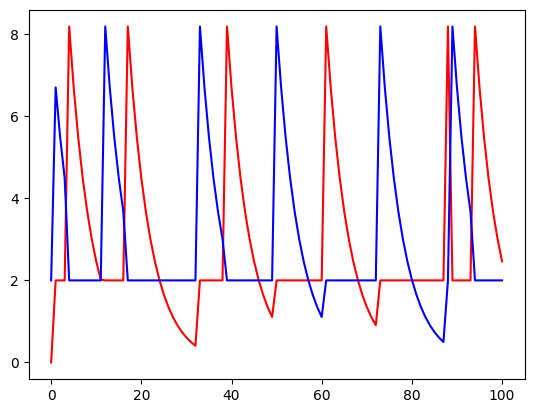

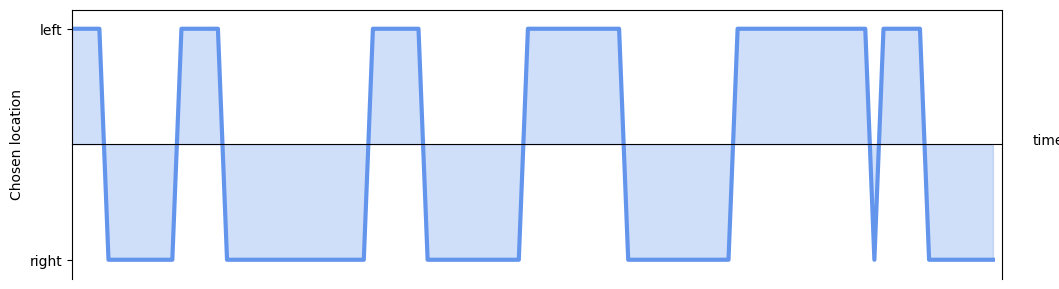

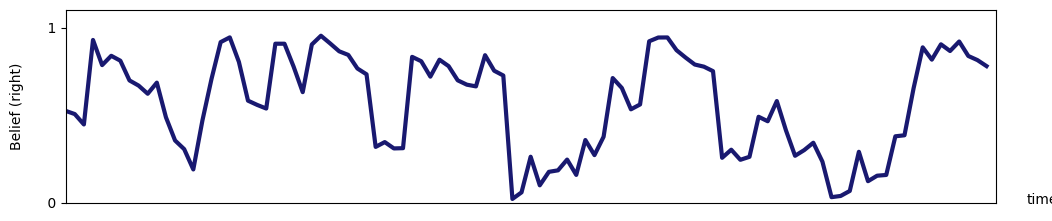

In [81]:
test_pomdp_value_iteration()